In [1]:
activities = {
    "Start": {"description": "Start", "predecessors": [], "optimistic": 0, "most_likely": 0, "pessimistic": 0},
    "A": {"description": "Vaccine Supply", "predecessors": ["Start"], "optimistic": 2, "most_likely": 4, "pessimistic": 7},
    "B": {"description": "Ensuring storage facilities", "predecessors": ["Start"], "optimistic": 3, "most_likely": 5, "pessimistic": 7},
    "C": {"description": "Allocate vaccination centers", "predecessors": ["B"], "optimistic": 2, "most_likely": 3, "pessimistic": 5},
    "D": {"description": "Allocate healthcare workers", "predecessors": ["C"], "optimistic": 3, "most_likely": 4, "pessimistic": 6},
    "E": {"description": "Train healthcare workers", "predecessors": ["D"], "optimistic": 5, "most_likely": 7, "pessimistic": 10},
    "F": {"description": "Public awareness campaign", "predecessors": ["Start"], "optimistic": 3, "most_likely": 5, "pessimistic": 8},
    "G": {"description": "Transport vaccine to cold storage", "predecessors": ["A", "B"], "optimistic": 3, "most_likely": 5, "pessimistic": 10},
    "H": {"description": "Verify vaccine quality at cold storage", "predecessors": ["G"], "optimistic": 1, "most_likely": 2, "pessimistic": 4},
    "I": {"description": "Distribute vaccine to vaccination centers", "predecessors": ["C", "H"], "optimistic": 2, "most_likely": 4, "pessimistic": 8},
    "J": {"description": "Set up vaccination centers", "predecessors": ["C"], "optimistic": 2, "most_likely": 4, "pessimistic": 6},
    "K": {"description": "Verify recipients", "predecessors": ["J"], "optimistic": 1, "most_likely": 3, "pessimistic": 5},
    "L": {"description": "Administer vaccine (first dose)", "predecessors": ["F", "I", "K"], "optimistic": 3, "most_likely": 5, "pessimistic": 7},
    "M": {"description": "Monitor recipients for vaccine reaction", "predecessors": ["L"], "optimistic": 1, "most_likely": 2, "pessimistic": 4},
    "N": {"description": "Schedule second dose", "predecessors": ["L"], "optimistic": 2, "most_likely": 3, "pessimistic": 5},
    "O": {"description": "Analyze campaign performance", "predecessors": ["L", "M", "N"], "optimistic": 3, "most_likely": 5, "pessimistic": 7},
    "End": {"description": "End", "predecessors": ["E", "O"], "optimistic": 0, "most_likely": 0, "pessimistic": 0}
}

for activity, details in activities.items():
    optimistic = details['optimistic']
    most_likely = details['most_likely']
    pessimistic = details['pessimistic']
    exp_t = (optimistic + 4 * most_likely + pessimistic) / 6
    activities[activity]['exp_t'] = exp_t

for activity, details in activities.items():
    print("Activity:",activity,"Expected duration:",activities[activity]['exp_t'])

Activity: Start Expected duration: 0.0
Activity: A Expected duration: 4.166666666666667
Activity: B Expected duration: 5.0
Activity: C Expected duration: 3.1666666666666665
Activity: D Expected duration: 4.166666666666667
Activity: E Expected duration: 7.166666666666667
Activity: F Expected duration: 5.166666666666667
Activity: G Expected duration: 5.5
Activity: H Expected duration: 2.1666666666666665
Activity: I Expected duration: 4.333333333333333
Activity: J Expected duration: 4.0
Activity: K Expected duration: 3.0
Activity: L Expected duration: 5.0
Activity: M Expected duration: 2.1666666666666665
Activity: N Expected duration: 3.1666666666666665
Activity: O Expected duration: 5.0
Activity: End Expected duration: 0.0


In [2]:
for activity, details in activities.items():
    optimistic = details['optimistic']
    most_likely = details['most_likely']
    pessimistic = details['pessimistic']
    var = ((pessimistic - optimistic)/6) ** 2
    activities[activity]['var'] = var

for activity, details in activities.items():
    print("Activity:",activity,"variance:",activities[activity]['var'])

Activity: Start variance: 0.0
Activity: A variance: 0.6944444444444445
Activity: B variance: 0.4444444444444444
Activity: C variance: 0.25
Activity: D variance: 0.25
Activity: E variance: 0.6944444444444445
Activity: F variance: 0.6944444444444445
Activity: G variance: 1.3611111111111114
Activity: H variance: 0.25
Activity: I variance: 1.0
Activity: J variance: 0.4444444444444444
Activity: K variance: 0.4444444444444444
Activity: L variance: 0.4444444444444444
Activity: M variance: 0.25
Activity: N variance: 0.25
Activity: O variance: 0.4444444444444444
Activity: End variance: 0.0


Critical Path: Start -> B -> G -> H -> I -> L -> N -> O -> End
Total Duration: 30.17 weeks


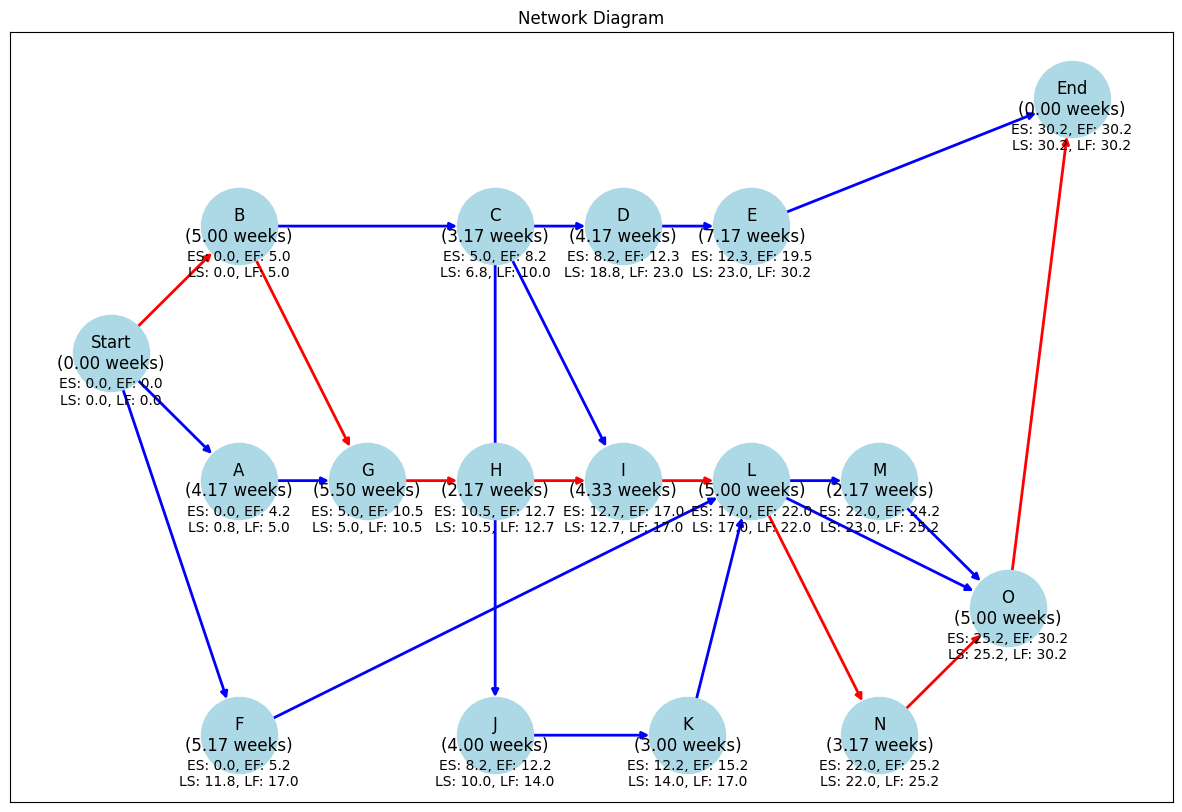

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
for activity, details in activities.items():
    G.add_node(activity, label=f"{activity}\n({details['exp_t']:.2f} weeks)")

for activity, details in activities.items():
    for predecessor in details['predecessors']:
        G.add_edge(predecessor, activity, weight=activities[activity]['exp_t'])

pos = {
    "Start": (-2, 0),
    "A": (0, -1),
    "B": (0, 1),
    "C": (4, 1),
    "D": (6, 1),
    "E": (8, 1),
    "F": (0, -3),
    "G": (2, -1),
    "H": (4, -1),
    "I": (6, -1),
    "J": (4, -3),
    "K": (7, -3),
    "L": (8, -1),
    "M": (10, -1),
    "N": (10, -3),
    "O": (12, -2),
    "End": (13, 2)
}

def calculate_schedule_params(graph, activities):
    for node in nx.topological_sort(graph):
        es = max((graph.nodes[pred]['EF'] for pred in graph.predecessors(node)), default=0)
        ef = es + activities[node]['exp_t']
        graph.nodes[node]['ES'] = es
        graph.nodes[node]['EF'] = ef


    for node in reversed(list(nx.topological_sort(graph))):
        lf = min((graph.nodes[succ]['LS'] for succ in graph.successors(node)), default=graph.nodes[node]['EF'])
        ls = lf - activities[node]['exp_t']
        graph.nodes[node]['LS'] = ls
        graph.nodes[node]['LF'] = lf

def identify_critical_path(graph):
    critical_path = []
    current_node = "End"
    while current_node != "Start":
        critical_path.append(current_node)
        predecessors = list(graph.predecessors(current_node))
        if not predecessors:
            break

        critical_predecessor = max(predecessors, key=lambda x: graph.nodes[x]['EF'])
        current_node = critical_predecessor

    critical_path.append("Start")
    critical_path.reverse()
    return critical_path

def calculate_critical_path_duration(graph):
    return max(graph.nodes[node]['EF'] for node in graph.nodes)

calculate_schedule_params(G, activities)

critical_path = identify_critical_path(G)
total_duration = calculate_critical_path_duration(G)

print("Critical Path:", " -> ".join(critical_path))
print("Total Duration:", f"{total_duration:.2f} weeks")

edge_colors = []
for u, v in G.edges():
    if u in critical_path and v in critical_path and critical_path.index(v) == critical_path.index(u) + 1:
        edge_colors.append('red')
    else:
        edge_colors.append('blue')

plt.figure(figsize=(15, 10))
nx.draw_networkx(
    G, pos, with_labels=False, node_size=3000, node_color='lightblue', edge_color=edge_colors, width=2, font_size=10
)
labels = nx.get_node_attributes(G, 'label')
nx.draw_networkx_labels(G, pos, labels, font_size=12)
plt.title('Network Diagram')

for node in G.nodes:
    es, ef, ls, lf = G.nodes[node]['ES'], G.nodes[node]['EF'], G.nodes[node]['LS'], G.nodes[node]['LF']
    plt.text(pos[node][0], pos[node][1] - 0.4, f"ES: {es:.1f}, EF: {ef:.1f}\nLS: {ls:.1f}, LF: {lf:.1f}", fontsize=10, ha='center')

plt.show()

In [4]:
def calculate_total_float(graph):
    total_float = {}
    for node in graph.nodes:
        es, ef, ls, lf = graph.nodes[node]['ES'], graph.nodes[node]['EF'], graph.nodes[node]['LS'], graph.nodes[node]['LF']
        total_float[node] = lf - ef
    return total_float

total_float = calculate_total_float(G)

for activity, tf in total_float.items():
    print("Activity:", activity, ", Total Float:", round(tf, 2))

Activity: Start , Total Float: 0.0
Activity: A , Total Float: 0.83
Activity: B , Total Float: 0.0
Activity: C , Total Float: 1.83
Activity: D , Total Float: 10.67
Activity: E , Total Float: 10.67
Activity: F , Total Float: 11.83
Activity: G , Total Float: 0.0
Activity: H , Total Float: 0.0
Activity: I , Total Float: 0.0
Activity: J , Total Float: 1.83
Activity: K , Total Float: 1.83
Activity: L , Total Float: 0.0
Activity: M , Total Float: 1.0
Activity: N , Total Float: 0.0
Activity: O , Total Float: 0.0
Activity: End , Total Float: 0.0


In [5]:
activities = {
    "A": {"normal_time": 4, "crash_time": 2, "normal_cost": 50, "crash_cost": 80},
    "B": {"normal_time": 5, "crash_time": 3, "normal_cost": 40, "crash_cost": 60},
    "C": {"normal_time": 3, "crash_time": 2, "normal_cost": 30, "crash_cost": 50},
    "D": {"normal_time": 4, "crash_time": 3, "normal_cost": 35, "crash_cost": 50},
    "E": {"normal_time": 7, "crash_time": 5, "normal_cost": 70, "crash_cost": 100},
    "F": {"normal_time": 5, "crash_time": 3, "normal_cost": 40, "crash_cost": 60},
    "G": {"normal_time": 5, "crash_time": 3, "normal_cost": 45, "crash_cost": 70},
    "H": {"normal_time": 2, "crash_time": 1, "normal_cost": 20, "crash_cost": 35},
    "I": {"normal_time": 4, "crash_time": 2, "normal_cost": 40, "crash_cost": 60},
    "J": {"normal_time": 4, "crash_time": 2, "normal_cost": 30, "crash_cost": 50},
    "K": {"normal_time": 3, "crash_time": 1, "normal_cost": 25, "crash_cost": 40},
    "L": {"normal_time": 5, "crash_time": 3, "normal_cost": 50, "crash_cost": 75},
    "M": {"normal_time": 2, "crash_time": 1, "normal_cost": 20, "crash_cost": 30},
    "N": {"normal_time": 3, "crash_time": 2, "normal_cost": 30, "crash_cost": 45},
    "O": {"normal_time": 5, "crash_time": 3, "normal_cost": 50, "crash_cost": 75}
}

crash_slopes = {}
for activity, details in activities.items():
    normal_time = details["normal_time"]
    crash_time = details["crash_time"]
    normal_cost = details["normal_cost"]
    crash_cost = details["crash_cost"]

    crash_slope = (crash_cost - normal_cost) / (normal_time - crash_time)
    crash_slopes[activity] = crash_slope

for activity, slope in crash_slopes.items():
    print("Activity:", activity, "Crash Slope:", slope,"crores")

Activity: A Crash Slope: 15.0 crores
Activity: B Crash Slope: 10.0 crores
Activity: C Crash Slope: 20.0 crores
Activity: D Crash Slope: 15.0 crores
Activity: E Crash Slope: 15.0 crores
Activity: F Crash Slope: 10.0 crores
Activity: G Crash Slope: 12.5 crores
Activity: H Crash Slope: 15.0 crores
Activity: I Crash Slope: 10.0 crores
Activity: J Crash Slope: 10.0 crores
Activity: K Crash Slope: 7.5 crores
Activity: L Crash Slope: 12.5 crores
Activity: M Crash Slope: 10.0 crores
Activity: N Crash Slope: 15.0 crores
Activity: O Crash Slope: 12.5 crores


In [6]:
activities = {
    "Start": {"description": "Start", "predecessors": [], "optimistic": 0, "most_likely": 0, "pessimistic": 0},
    "A": {"description": "Vaccine Supply", "predecessors": ["Start"], "optimistic": 2, "most_likely": 4, "pessimistic": 7},
    "B": {"description": "Ensuring storage facilities", "predecessors": ["Start"], "optimistic": 2, "most_likely": 4, "pessimistic": 6},
    "C": {"description": "Allocate vaccination centers", "predecessors": ["B"], "optimistic": 2, "most_likely": 3, "pessimistic": 5},
    "D": {"description": "Allocate healthcare workers", "predecessors": ["C"], "optimistic": 3, "most_likely": 4, "pessimistic": 6},
    "E": {"description": "Train healthcare workers", "predecessors": ["D"], "optimistic": 5, "most_likely": 7, "pessimistic": 10},
    "F": {"description": "Public awareness campaign", "predecessors": ["Start"], "optimistic": 3, "most_likely": 5, "pessimistic": 8},
    "G": {"description": "Transport vaccine to cold storage", "predecessors": ["A", "B"], "optimistic": 3, "most_likely": 5, "pessimistic": 10},
    "H": {"description": "Verify vaccine quality at cold storage", "predecessors": ["G"], "optimistic": 1, "most_likely": 1, "pessimistic": 3},
    "I": {"description": "Distribute vaccine to vaccination centers", "predecessors": ["C", "H"], "optimistic": 1, "most_likely": 3, "pessimistic": 7},
    "J": {"description": "Set up vaccination centers", "predecessors": ["C"], "optimistic": 2, "most_likely": 4, "pessimistic": 6},
    "K": {"description": "Verify recipients", "predecessors": ["J"], "optimistic": 1, "most_likely": 3, "pessimistic": 5},
    "L": {"description": "Administer vaccine (first dose)", "predecessors": ["F", "I", "K"], "optimistic": 3, "most_likely": 5, "pessimistic": 7},
    "M": {"description": "Monitor recipients for vaccine reaction", "predecessors": ["L"], "optimistic": 1, "most_likely": 2, "pessimistic": 4},
    "N": {"description": "Schedule second dose", "predecessors": ["L"], "optimistic": 2, "most_likely": 3, "pessimistic": 5},
    "O": {"description": "Analyze campaign performance", "predecessors": ["L", "M", "N"], "optimistic": 2, "most_likely": 4, "pessimistic": 6},
    "End": {"description": "End", "predecessors": ["E", "O"], "optimistic": 0, "most_likely": 0, "pessimistic": 0}
}
for activity, details in activities.items():
    optimistic = details['optimistic']
    most_likely = details['most_likely']
    pessimistic = details['pessimistic']
    exp_t = (optimistic + 4 * most_likely + pessimistic) / 6
    activities[activity]['exp_t'] = exp_t

for activity, details in activities.items():
    print("Activity:",activity,"Expected duration:",activities[activity]['exp_t'])

import networkx as nx

G = nx.DiGraph()
for activity, details in activities.items():
    G.add_node(activity, label=f"{activity}\n({details['exp_t']:.2f} days)")

for activity, details in activities.items():
    for predecessor in details['predecessors']:
        G.add_edge(predecessor, activity, weight=activities[activity]['exp_t'])


def calculate_schedule_params(graph, activities):
    for node in nx.topological_sort(graph):
        es = max((graph.nodes[pred]['EF'] for pred in graph.predecessors(node)), default=0)
        ef = es + activities[node]['exp_t']
        graph.nodes[node]['ES'] = es
        graph.nodes[node]['EF'] = ef
    for node in reversed(list(nx.topological_sort(graph))):
        lf = min((graph.nodes[succ]['LS'] for succ in graph.successors(node)), default=graph.nodes[node]['EF'])
        ls = lf - activities[node]['exp_t']
        graph.nodes[node]['LS'] = ls
        graph.nodes[node]['LF'] = lf

def identify_critical_path(graph):
    critical_path = []
    current_node = "End"
    while current_node != "Start":
        critical_path.append(current_node)
        predecessors = list(graph.predecessors(current_node))
        if not predecessors:
            break

        critical_predecessor = max(predecessors, key=lambda x: graph.nodes[x]['EF'])
        current_node = critical_predecessor

    critical_path.append("Start")
    critical_path.reverse()
    return critical_path

def calculate_critical_path_duration(graph):
    return max(graph.nodes[node]['EF'] for node in graph.nodes)

calculate_schedule_params(G, activities)

critical_path = identify_critical_path(G)
total_duration = calculate_critical_path_duration(G)

print("Total Duration:", round(total_duration,2),"days")

Activity: Start Expected duration: 0.0
Activity: A Expected duration: 4.166666666666667
Activity: B Expected duration: 4.0
Activity: C Expected duration: 3.1666666666666665
Activity: D Expected duration: 4.166666666666667
Activity: E Expected duration: 7.166666666666667
Activity: F Expected duration: 5.166666666666667
Activity: G Expected duration: 5.5
Activity: H Expected duration: 1.3333333333333333
Activity: I Expected duration: 3.3333333333333335
Activity: J Expected duration: 4.0
Activity: K Expected duration: 3.0
Activity: L Expected duration: 5.0
Activity: M Expected duration: 2.1666666666666665
Activity: N Expected duration: 3.1666666666666665
Activity: O Expected duration: 4.0
Activity: End Expected duration: 0.0
Total Duration: 26.5 days


In [7]:
def calculate_vaccination_time(persons, health_centers, vaccination_time_per_person, stations_per_center):
    total_stations = health_centers * stations_per_center
    total_time_minutes = (persons * vaccination_time_per_person) / total_stations
    if total_time_minutes <= 60:
        total_time_hours = total_time_minutes
    else:
        total_time_hours = total_time_minutes / 60
    return total_time_minutes, total_time_hours

persons = 100
health_centers = 1
stations_per_center = 3
vaccination_time_per_person = 10

total_time_minutes, total_time_hours = calculate_vaccination_time(persons, health_centers, vaccination_time_per_person, stations_per_center)


if total_time_minutes <= 60:
    print("Total time required to vaccinate", persons,":",round(total_time_minutes,2), "minutes")
else:
    print("Total time required to vaccinate",persons,":",round(total_time_hours,2), "hours")

Total time required to vaccinate 100 : 5.56 hours
